# Convert and Optimize YOLOv8 real-time object detection with OpenVINO™

Real-time object detection is often used as a key component in computer vision systems.
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLOv8 with OpenVINO. We consider the steps required for object detection scenario.

The tutorial consists of the following steps:
- Prepare the PyTorch model.
- Download and prepare a dataset.
- Validate the original model.
- Convert the PyTorch model to OpenVINO IR.
- Validate the converted model.
- Prepare and run optimization pipeline.
- Compare performance of the FP32 and quantized models.
- Compare accuracy of the FP32 and quantized models.
- Other optimization possibilities with OpenVINO api
- Live demo



#### Table of contents:

- [Get PyTorch model](#Get-PyTorch-model)
    - [Prerequisites](#Prerequisites)
- [Instantiate model](#Instantiate-model)
    - [Convert model to OpenVINO IR](#Convert-model-to-OpenVINO-IR)
    - [Verify model inference](#Verify-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Test on single image](#Test-on-single-image)
- [Check model accuracy on the dataset](#Check-model-accuracy-on-the-dataset)
    - [Download the validation dataset](#Download-the-validation-dataset)
    - [Define validation function](#Define-validation-function)
    - [Configure Validator helper and create DataLoader](#Configure-Validator-helper-and-create-DataLoader)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Validate Quantized model inference](#Validate-Quantized-model-inference)
- [Compare the Original and Quantized Models](#Compare-the-Original-and-Quantized-Models)
    - [Compare performance object detection models](#Compare-performance-object-detection-models)
    - [Validate quantized model accuracy](#Validate-quantized-model-accuracy)
- [Next steps](#Next-steps)
    - [Async inference pipeline](#Async-inference-pipeline)
    - [Integration preprocessing to model](#Integration-preprocessing-to-model)
        - [Initialize PrePostProcessing API](#Initialize-PrePostProcessing-API)
        - [Define input data format](#Define-input-data-format)
        - [Describe preprocessing steps](#Describe-preprocessing-steps)
        - [Integrating Steps into a Model](#Integrating-Steps-into-a-Model)
        - [Postprocessing](#Postprocessing)
- [Live demo](#Live-demo)
    - [Run Live Object Detection](#Run-Live-Object-Detection)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/yolov8-optimization/yolov8-object-detection.ipynb" />


## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, the creators of the model provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR. Therefore, we do not need to do these steps manually.

#### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [6]:
%pip install -q "openvino>=2024.0.0" "nncf>=2.9.0"
%pip install -q "torch>=2.1" "torchvision>=0.16" "ultralytics==8.2.24" onnx tqdm opencv-python --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [7]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer, device_widget, quantization_widget

In [8]:
# Download a test sample
#IMAGE_PATH = Path("./data/img1.jpg")
IMAGE_PATH = Path("./data/const1.jpg")
download_file(
    url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent,
)


WindowsPath('R:/Intel Indicon/sitesafeai/data/const1.jpg')

## Instantiate model
[back to top ⬆️](#Table-of-contents:)

There are [several models](https://docs.ultralytics.com/tasks/detect/) available in the original repository, targeted for different tasks. For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically). 

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes for object detection model. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:

In [9]:
models_dir = Path("./best_openvino_model")
models_dir.mkdir(exist_ok=True)

C:\Users\Parul\AppData\Roaming\Python\Python311\site-packages\ultralytics\nn\tasks.py:732: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location


image 1/1 r:\Intel Indicon\sitesafeai\data\const1.jpg: 640x640 2 Hardhats, 4 NO-Masks, 2 Persons, 4 Safety Vests, 173.1ms
Speed: 6.0ms preprocess, 173.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


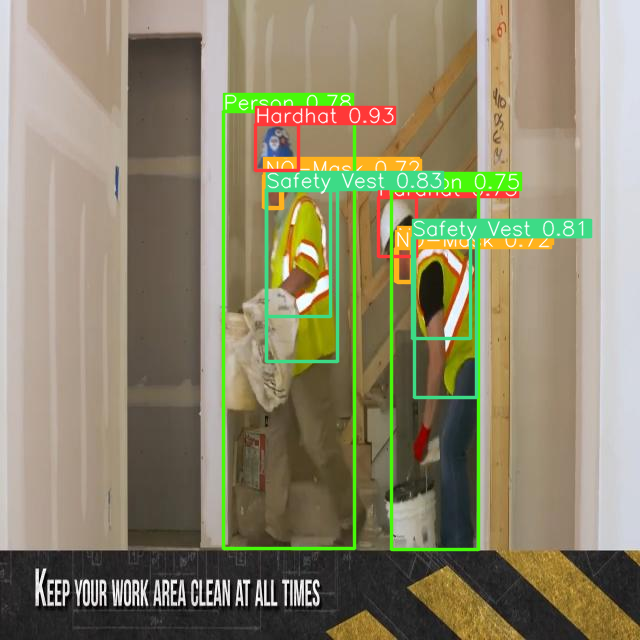

In [10]:
from PIL import Image
from ultralytics import YOLO

DET_MODEL_NAME = "best"

det_model = YOLO(models_dir / f"{DET_MODEL_NAME}.pt")
label_map = det_model.model.names

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

### Convert model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [11]:
# object detection model
det_model_path = models_dir / f"{DET_MODEL_NAME}.xml"
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)

### Verify model inference
[back to top ⬆️](#Table-of-contents:)

We can reuse the base model pipeline for pre- and postprocessing just replacing the inference method where we will use the IR model for inference.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [12]:
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
device = device_widget()

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

### Test on single image
[back to top ⬆️](#Table-of-contents:)

Now, once we have defined preprocessing and postprocessing steps, we are ready to check model prediction for object detection.


image 1/1 r:\Intel Indicon\sitesafeai\data\const1.jpg: 640x640 2 Hardhats, 4 NO-Masks, 2 Persons, 4 Safety Vests, 54.9ms
Speed: 5.0ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


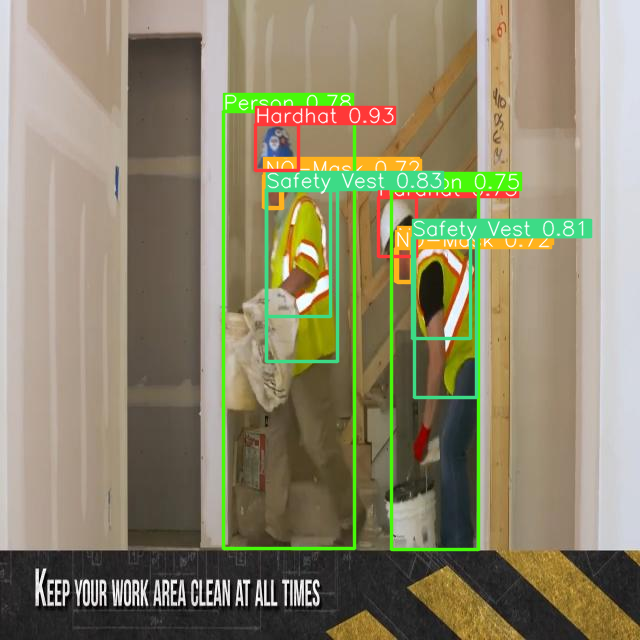

In [14]:
import torch
import openvino as ov

core = ov.Core()

det_ov_model = core.read_model(det_model_path)

ov_config = {}
if device.value != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
det_compiled_model = core.compile_model(det_ov_model, device.value, ov_config)


def infer(*args):
    result = det_compiled_model(args)
    return torch.from_numpy(result[0])


det_model.predictor.inference = infer
det_model.predictor.model.pt = False

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

## Check model accuracy on the dataset
[back to top ⬆️](#Table-of-contents:)

For comparing the optimized model result with the original, it is good to know some measurable results in terms of model accuracy on the validation dataset. 


### Download the validation dataset
[back to top ⬆️](#Table-of-contents:)

YOLOv8 is pre-trained on the COCO dataset, so to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the author of the model, for use with the original model evaluation function.

>**Note**: The initial dataset download may take a few minutes to complete. The download speed will vary depending on the quality of your internet connection.

In [15]:
from pathlib import Path

# Dataset folder paths
DATASETS_DIR = Path("./datasets")  # Update this to your dataset directory


OUT_DIR = DATASETS_DIR
DATA_PATH = OUT_DIR/"valid"
CFG_PATH = OUT_DIR / "data.yaml"

# Check if the dataset structure is correct
assert (CFG_PATH).exists(), "Train images folder missing!"
assert (DATA_PATH / "images").exists(), "Validation images folder missing!"


### Define validation function
[back to top ⬆️](#Table-of-contents:)


In [16]:
import numpy as np

from tqdm.notebook import tqdm
from ultralytics.utils.metrics import ConfusionMatrix


def test(
    model: ov.Model,
    core: ov.Core,
    data_loader: torch.utils.data.DataLoader,
    validator,
    num_samples: int = None,
):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        validator: instance of validator class
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = dict(tp=[], conf=[], pred_cls=[], target_cls=[])
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(tqdm(data_loader, total=num_samples)):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        preds = torch.from_numpy(results[compiled_model.output(0)])
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats: np.ndarray, total_images: int, total_objects: int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes:")
    mp, mr, map50, mean_ap = (
        stats["metrics/precision(B)"],
        stats["metrics/recall(B)"],
        stats["metrics/mAP50(B)"],
        stats["metrics/mAP50-95(B)"],
    )
    # Print results
    print("    Best mean average:")
    s = ("%20s" + "%12s" * 6) % (
        "Class",
        "Images",
        "Labels",
        "Precision",
        "Recall",
        "mAP@.5",
        "mAP@.5:.95",
    )
    print(s)
    pf = "%20s" + "%12i" * 2 + "%12.3g" * 4  # print format
    print(pf % ("all", total_images, total_objects, mp, mr, map50, mean_ap))
    if "metrics/precision(M)" in stats:
        s_mp, s_mr, s_map50, s_mean_ap = (
            stats["metrics/precision(M)"],
            stats["metrics/recall(M)"],
            stats["metrics/mAP50(M)"],
            stats["metrics/mAP50-95(M)"],
        )
        # Print results
        print("    Macro average mean:")
        s = ("%20s" + "%12s" * 6) % (
            "Class",
            "Images",
            "Labels",
            "Precision",
            "Recall",
            "mAP@.5",
            "mAP@.5:.95",
        )
        print(s)
        pf = "%20s" + "%12i" * 2 + "%12.3g" * 4  # print format
        print(pf % ("all", total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))

### Configure Validator helper and create DataLoader
[back to top ⬆️](#Table-of-contents:)

The original model repository uses a `Validator` wrapper, which represents the accuracy validation pipeline. It creates dataloader and evaluation metrics and updates metrics on each data batch produced by the dataloader. Besides that, it is responsible for data preprocessing and results postprocessing. For class initialization, the configuration should be provided. We will use the default setup, but it can be replaced with some parameters overriding to test on custom data. The model has connected the `ValidatorClass` method, which creates a validator class instance.

In [17]:
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class
from ultralytics.data.utils import check_det_dataset

args = get_cfg(cfg=DEFAULT_CFG)
args.data = str(CFG_PATH)

In [18]:
det_validator = det_model.task_map[det_model.task]["validator"](args=args)

In [19]:
det_validator.data = check_det_dataset(r"R:\Intel Indicon\sitesafeai\data.yaml")
det_validator.stride = 32
det_data_loader = det_validator.get_dataloader(OUT_DIR, 1)

val: Scanning datasets\test\labels... 2801 images, 24 backgrounds, 0 corrupt: 100%|██████████| 2801/2801 [00:02<00:00, 1296.15it/s]

val: WARNING  datasets\train\images\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
val: WARNING  datasets\train\images\construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


val: New cache created: datasets\test\labels.cache


In [20]:
from ultralytics.data.utils import check_det_dataset



# Set up validator properties based on the dataset
det_validator.is_coco = False  # Not COCO dataset
det_validator.nc = 10  # Number of classes as per your data.yaml
det_validator.names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']  # Class names

# Optional: Map class indices to the names if needed for metrics
det_validator.metrics.names = det_validator.names

# You can now create a data loader for validation
det_data_loader = det_validator.get_dataloader(
    dataset_path="./datasets/valid/images",  # Path to validation dataset images
    batch_size=1  # Set batch size
)

# If you have a model and want to associate class info with it
det_model.model.names = det_validator.names  # Assign class names to the model


val: Scanning datasets\valid\labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1771.37it/s]

val: New cache created: datasets\valid\labels.cache


After definition test function and validator creation, we are ready for getting accuracy metrics
>**Note**: Model evaluation is time consuming process and can take several minutes, depending on the hardware. For reducing calculation time, we define `num_samples` parameter with evaluation subset size, but in this case, accuracy can be noncomparable with originally reported by the authors of the model, due to validation subset difference.
*To validate the models on the full dataset set `NUM_TEST_SAMPLES = None`.*

In [21]:
%pip install ipywidgets --upgrade

%pip install notebook
%pip install ipywidgets
NUM_TEST_SAMPLES = 300

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [22]:
from tqdm import tqdm

det_validator.names = {i: name for i, name in enumerate([
    'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 
    'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle'
])}
det_validator.metrics.names = det_validator.names

# Run the test
fp_det_stats = test(det_ov_model, core, det_data_loader, det_validator, num_samples=None)


100%|██████████| 114/114 [00:07<00:00, 15.82it/s]


In [23]:
print_stats(fp_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         114         697       0.914       0.673       0.752       0.436


`print_stats` reports the following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve aggregated over all classes in the dataset, where `t` is the Intersection Over Union (IOU) threshold, degree of overlapping between ground truth and predicted objects. Therefore, `mAP@.5` indicates that mean average precision is calculated at 0.5 IOU threshold, `mAP@.5:.95` - is calculated on range IOU thresholds from 0.5 to 0.95 with step 0.05.

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv8.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.runtime.serialize` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [24]:
%pip install ipywidgets widgetsnbextension



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
from tqdm import tqdm

int8_model_det_path = models_dir / f"{DET_MODEL_NAME}_openvino_int8_model/{DET_MODEL_NAME}.xml"
quantized_det_model = None

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [26]:
# Fetch skip_kernel_extension module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define a transformation function for getting only input tensors.

In [27]:
%%skip not $to_quantize.value

import nncf
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [28]:
%%skip not $to_quantize.value

ignored_scope = nncf.IgnoredScope( # post-processing
    subgraphs=[
        nncf.Subgraph(inputs=['__module.model.22/aten::cat/Concat',
                              '__module.model.22/aten::cat/Concat_1',
                              '__module.model.22/aten::cat/Concat_2'],
                      outputs=['__module.model.22/aten::cat/Concat_7'])
    ]
)

# Detection model
quantized_det_model = nncf.quantize(
    det_ov_model,
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED
)


Output()

Output()

In [29]:
%%skip not $to_quantize.value

print(f"Quantized detection model will be saved to {int8_model_det_path}")
ov.save_model(quantized_det_model, str(int8_model_det_path))

Quantized detection model will be saved to best_openvino_model\best_openvino_int8_model\best.xml


### Validate Quantized model inference
[back to top ⬆️](#Table-of-contents:)

`nncf.quantize` returns the OpenVINO Model class instance, which is suitable for loading on a device for making predictions. `INT8` model input data and output result formats have no difference from the floating point model representation. Therefore, we can reuse the same `detect` function defined above for getting the `INT8` model result on the image.

In [30]:
%%skip not $to_quantize.value

device


image 1/1 r:\Intel Indicon\sitesafeai\data\const1.jpg: 640x640 2 Hardhats, 5 NO-Masks, 3 Persons, 4 Safety Vests, 29.9ms
Speed: 10.1ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


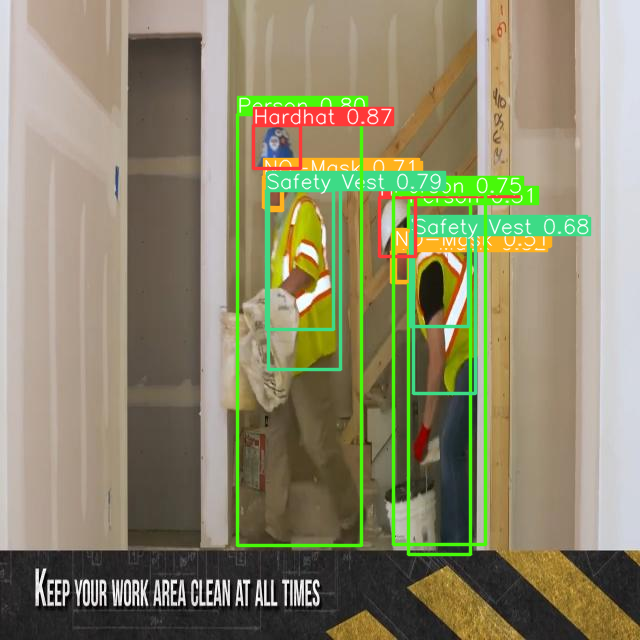

In [31]:
%%skip not $to_quantize.value

ov_config = {}
if device.value != "CPU":
    quantized_det_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
quantized_det_compiled_model = core.compile_model(quantized_det_model, device.value, ov_config)


def infer(*args):
    result = quantized_det_compiled_model(args)
    return torch.from_numpy(result[0])

det_model.predictor.inference = infer

res = det_model(IMAGE_PATH)
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

## Compare the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)


### Compare performance object detection models
[back to top ⬆️](#Table-of-contents:)

Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) to measure the inference performance of the `FP32` and `INT8` models.

> **Note**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [32]:
%%skip not $to_quantize.value

device

In [33]:
if int8_model_det_path.exists():
    # Inference FP32 model (OpenVINO IR)
    !benchmark_app -m $det_model_path -d $device.value -api async -shape "[1,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.5.0-17288-7975fa5da0c-refs/pull/3856/head
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.5.0-17288-7975fa5da0c-refs/pull/3856/head
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 24.97 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_5) : f32 / [...] / [1,14,8400]
[S

In [34]:
if int8_model_det_path.exists():
    # Inference INT8 model (OpenVINO IR)
    !benchmark_app -m $int8_model_det_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.5.0-17288-7975fa5da0c-refs/pull/3856/head
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.5.0-17288-7975fa5da0c-refs/pull/3856/head
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 41.33 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_5) : f32 / [...] / [1,14,8400]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model 

### Validate quantized model accuracy
[back to top ⬆️](#Table-of-contents:)

As we can see, there is no significant difference between `INT8` and float model result in a single image test. To understand how quantization influences model prediction precision, we can compare model accuracy on a dataset.

In [35]:
%%skip not $to_quantize.value

int8_det_stats = test(quantized_det_model, core, det_data_loader, det_validator, num_samples=NUM_TEST_SAMPLES)

 38%|███▊      | 114/300 [00:03<00:05, 31.02it/s]


In [36]:
%%skip not $to_quantize.value

print("FP32 model accuracy")
print_stats(fp_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(int8_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

FP32 model accuracy
Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         114         697       0.914       0.673       0.752       0.436
INT8 model accuracy
Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         114         697       0.865        0.66       0.734        0.41


Great! Looks like accuracy was changed, but not significantly and it meets passing criteria.

## Next steps
[back to top ⬆️](#Table-of-contents:)
This section contains suggestions on how to additionally improve the performance of your application using OpenVINO.

### Async inference pipeline
[back to top ⬆️](#Table-of-contents:)
The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to [Async API tutorial](../async-api/async-api.ipynb)

### Integration preprocessing to model
[back to top ⬆️](#Table-of-contents:)

Preprocessing API enables making preprocessing a part of the model reducing application code and dependency on additional image processing libraries. 
The main advantage of Preprocessing API is that preprocessing steps will be integrated into the execution graph and will be performed on a selected device (CPU/GPU etc.) rather than always being executed on CPU as part of an application. This will improve selected device utilization.

For more information, refer to the overview of [Preprocessing API](https://docs.openvino.ai/2024/openvino-workflow/running-inference/optimize-inference/optimize-preprocessing/preprocessing-api-details.html).

For example, we can integrate converting input data layout and normalization defined in `image_to_tensor` function.

The integration process consists of the following steps:
1. Initialize a PrePostProcessing object.
2. Define the input data format.
3. Describe preprocessing steps.
4. Integrating Steps into a Model.

#### Initialize PrePostProcessing API
[back to top ⬆️](#Table-of-contents:)

The `openvino.preprocess.PrePostProcessor` class enables specifying preprocessing and postprocessing steps for a model.

In [37]:
from openvino.preprocess import PrePostProcessor

ppp = PrePostProcessor(quantized_det_model if quantized_det_model is not None else det_model)

#### Define input data format
[back to top ⬆️](#Table-of-contents:)

To address particular input of a model/preprocessor, the `input(input_id)` method, where `input_id` is a positional index or input tensor name for input in `model.inputs`, if a model has a single input, `input_id` can be omitted.
After reading the image from the disc, it contains U8 pixels in the `[0, 255]` range and is stored in the `NHWC` layout. To perform a preprocessing conversion, we should provide this to the tensor description.

In [38]:
ppp.input(0).tensor().set_shape([1, 640, 640, 3]).set_element_type(ov.Type.u8).set_layout(ov.Layout("NHWC"))
pass

To perform layout conversion, we also should provide information about layout expected by model

#### Describe preprocessing steps
[back to top ⬆️](#Table-of-contents:)

Our preprocessing function contains the following steps:
* Convert the data type from `U8` to `FP32`.
* Convert the data layout from `NHWC` to `NCHW` format.
* Normalize each pixel by dividing on scale factor 255.

`ppp.input(input_id).preprocess()` is used for defining a sequence of preprocessing steps:

In [39]:
ppp.input(0).preprocess().convert_element_type(ov.Type.f32).convert_layout(ov.Layout("NCHW")).scale([255.0, 255.0, 255.0])

print(ppp)

Input "x":
    User's input tensor: [1,640,640,3], [N,H,W,C], u8
    Model's expected tensor: [1,3,?,?], [N,C,H,W], f32
    Pre-processing steps (3):
      convert type (f32): ([1,640,640,3], [N,H,W,C], u8) -> ([1,640,640,3], [N,H,W,C], f32)
      convert layout [N,C,H,W]: ([1,640,640,3], [N,H,W,C], f32) -> ([1,3,640,640], [N,C,H,W], f32)
      scale (255,255,255): ([1,3,640,640], [N,C,H,W], f32) -> ([1,3,640,640], [N,C,H,W], f32)



#### Integrating Steps into a Model
[back to top ⬆️](#Table-of-contents:)

Once the preprocessing steps have been finished, the model can be finally built. Additionally, we can save a completed model to OpenVINO IR, using `openvino.runtime.serialize`.

In [40]:
quantized_model_with_preprocess = ppp.build()

with_preprocess_path = (
    int8_model_det_path.with_name(f"{DET_MODEL_NAME}_with_preprocess.xml")
    if quantized_det_model is not None
    else det_model_path.with_name(f"{DET_MODEL_NAME}_with_preprocess.xml")
)
ov.save_model(quantized_model_with_preprocess, str(with_preprocess_path))

The model with integrated preprocessing is ready for loading to a device.

In [41]:
from typing import Tuple, Dict
import cv2
import numpy as np
from ultralytics.utils.plotting import colors
import random


def plot_one_box(
    box: np.ndarray,
    img: np.ndarray,
    color: Tuple[int, int, int] = None,
    label: str = None,
    line_thickness: int = 5,
):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(
            img,
            label,
            (c1[0], c1[1] - 2),
            0,
            tl / 3,
            [225, 255, 255],
            thickness=tf,
            lineType=cv2.LINE_AA,
        )

    return img


def draw_results(results: Dict, source_image: np.ndarray, label_map: Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        Image with boxes
    """
    boxes = results["det"]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f"{label_map[int(lbl)]} {conf:.2f}"
        source_image = plot_one_box(xyxy, source_image, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

##### Postprocessing
[back to top ⬆️](#Table-of-contents:)

The model output contains detection boxes candidates, it is a tensor with the [-1,84,-1] shape in the B,84,N format, where:

B - batch size
N - number of detection boxes
For getting the final prediction, we need to apply a non-maximum suppression algorithm and rescale box coordinates to the original image size.

Finally, detection box has the [x, y, h, w, class_no_1, ..., class_no_80] format, where:

(x, y) - raw coordinates of box center
h, w - raw height and width of the box
class_no_1, ..., class_no_80 - probability distribution over the classes.

In [42]:
from typing import Tuple
from ultralytics.utils import ops
import torch
import numpy as np


def letterbox(
    img: np.ndarray,
    new_shape: Tuple[int, int] = (640, 640),
    color: Tuple[int, int, int] = (114, 114, 114),
    auto: bool = False,
    scale_fill: bool = False,
    scaleup: bool = False,
    stride: int = 32,
):
    """
    Resize image and padding for detection. Takes image as input,
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints

    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size


    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def postprocess(
    pred_boxes: np.ndarray,
    input_hw: Tuple[int, int],
    orig_img: np.ndarray,
    min_conf_threshold: float = 0.25,
    nms_iou_threshold: float = 0.7,
    agnosting_nms: bool = False,
    max_detections: int = 300,
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label]
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det": max_detections}
    preds = ops.non_max_suppression(torch.from_numpy(pred_boxes), min_conf_threshold, nms_iou_threshold, nc=80, **nms_kwargs)

    results = []
    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
        results.append({"det": pred})

    return results

Now, we can skip these preprocessing steps in detect function:

In [43]:
#
import numpy as np
import torch
import torchvision

def postprocess(pred, input_hw, original_image):
    """
    YOLOv8 model postprocessing function. 
    Applied non-maximum suppression algorithm to detections and rescale boxes to original image size 
    
    Parameters:
    pred (np.ndarray): Model output with shape (1, 14, 8400)
    input_hw (tuple): Input image height and width
    original_image (np.ndarray): Original input image
    
    Returns:
    Dict with detections
    """
    # Transpose and reshape the prediction
    pred = pred.squeeze()  # Remove batch dimension
    pred = pred.transpose()  # Transpose to (8400, 14)
    
    # Split predictions
    # Typically, YOLOv8 output is [x, y, w, h, conf, class_prob_0, ..., class_prob_79]
    boxes = pred[:, :4]  # First 4 columns are box coordinates
    scores = pred[:, 4]  # 5th column is confidence
    classes = pred[:, 5:].argmax(axis=1)  # Get class with max probability
    
    # Convert to x1, y1, x2, y2 format
    x_center, y_center, width, height = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = x_center - width / 2
    y1 = y_center - height / 2
    x2 = x_center + width / 2
    y2 = y_center + height / 2
    
    # Combine into a single array
    boxes_xyxy = np.column_stack((x1, y1, x2, y2, scores, classes))
    
    # Filter low confidence detections
    conf_mask = scores > 0.5  # adjust threshold as needed
    boxes_xyxy = boxes_xyxy[conf_mask]
    
    # Optional: Non-maximum suppression
    if len(boxes_xyxy) > 0:
        # Convert to torch for NMS
        boxes_tensor = torch.from_numpy(boxes_xyxy[:, :4])
        scores_tensor = torch.from_numpy(boxes_xyxy[:, 4])
        
        # Perform NMS
        keep = torchvision.ops.nms(boxes_tensor, scores_tensor, iou_threshold=0.45)
        
        # Filter boxes
        final_detections = boxes_xyxy[keep.numpy()]
        
        # Return in the format expected by draw_results
        return {"det": final_detections}
    
    # Return empty detection if no boxes found
    return {"det": np.empty((0, 6))}

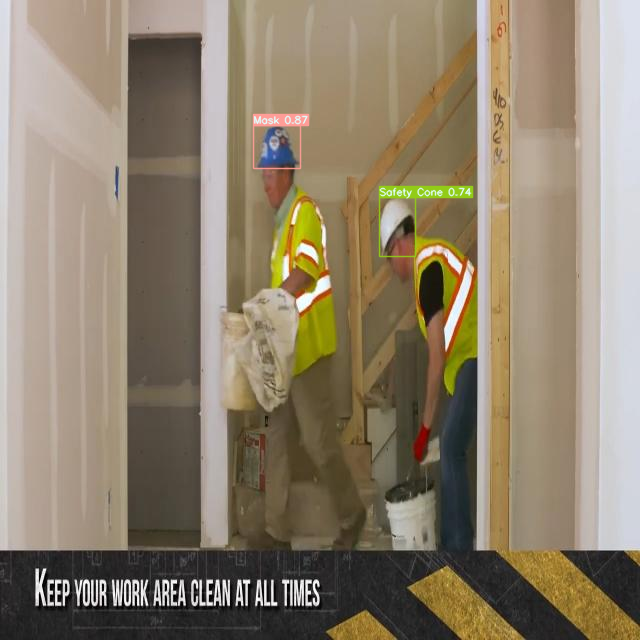

In [44]:
#

def detect_without_preprocess(image: np.ndarray, model: ov.Model):
    """
    OpenVINO YOLOv8 model with integrated preprocessing inference function. 
    Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    output_layer = model.output(0)
    
    # Convert to uint8 and ensure shape is [1, 640, 640, 3]
    input_tensor = image.astype(np.uint8)
    input_tensor = np.expand_dims(input_tensor, axis=0)
    
    input_hw = image.shape[:2]
    
    # Debug: Print model output details
    result = model(input_tensor)[output_layer]
    
    try:
        detections = postprocess(result, input_hw, image)
        return detections
    except Exception as e:
        print("Postprocessing Error:", e)
        import traceback
        traceback.print_exc()
        return None

compiled_model = core.compile_model(quantized_model_with_preprocess, device.value)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect_without_preprocess(input_image, compiled_model)
image_with_boxes = draw_results(detections, input_image, label_map)
Image.fromarray(image_with_boxes)

## Live demo
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

In [45]:
import collections
import time
from IPython import display

det_ov_model


# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_model,
    device=device.value,
):
    player = None
    ov_config = {}
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)

    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0])

    det_model.predictor.inference = infer

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            detections = det_model(input_image, verbose=False)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Object Detection
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try live inference on your webcam set `WEBCAM_INFERENCE = True`

Run the object detection:

In [46]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "./data/construction_site_video.mp4"

In [49]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'GPU', 'AUTO'), value='GPU')

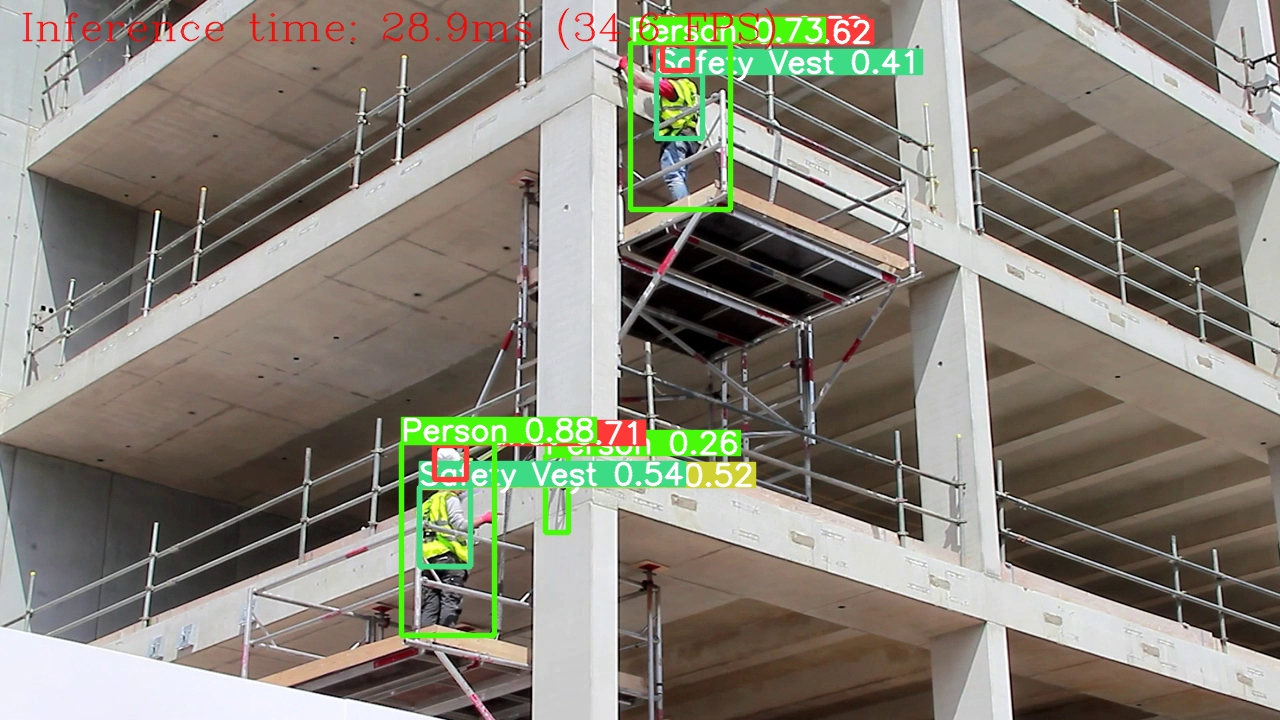

Source ended


In [50]:
run_object_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=det_ov_model,
    device=device.value,
)